# Preliminary instruction

To follow the code in this chapter, the `yfinance` package must be installed in your environment. If you do not have this installed yet, review Chapter 4 for instructions on how to do so.

# SCREENING ACROSS THE S&P 500 INDEX

### Floor/Ceiling regime definition

Unlike the previous methodologies, the floor/ceiling regime definitionis computationally intense. It is in two parts:

1. Swing detection is a succession of functions. It is broadly split in two parts:
    1. historical swing detection: all the swings leading up to the latest one
        1. historical_swings: this uses find_peaks to find small peaks. This function loops over series coming from the hilo alternation function to zoom out
        2. hilo alternation: this function simply reduces series to alternate highs and lows
    2. latest swing detection: rapid fire functions to detect the latest swing in real time
        1. cleanup_latest_swing: Eliminate false positives Swing High/Low last swing
        2. latest_swing_variables: Set-up arguments for latest swing High or Low
        3. test_distance: noise filter: removes short amplitude noise
        4. average_true_range: classic volatility in 1 line of code
        5. retest_swing: retest method
        6. retracement_swing: alternative swing detection: retracement from high/low
  
  
2. Floor/ceiling regime definition uses swings detected above
    1. Classic regime definition:
        1. Bullish: (swing low - bottom)/std > threshold
        2. Bearish: (swing high - top)/std < threshold
    2. Handling exception:
        1. Bearish: Low < swing low
        2. Bullish: High > swing high

### Swings and Regime summary functions

These two functions call the functions necessary to calculate the floor/ceiling.

1. swings: A simple toggle rel calculates either the absolute (rel = False) or the relative swings

2. regime: lvl refers to the swing levels used to calculate regime. For example, Hi2/Lo2 refers to level 2 swings (reduced twice), rH3/rL3 to relative level 3 etc.

### Graph combo

This verbose function visualises all the above regime definition methodologies

### New Functions to process data

Those two functions were not published earlier in the book.

1. yf_droplevel(batch_download,ticker)
The batch downoload returns a multiindex dataframe. This drops level from multiindex df to single stock level. 
    
2. last_row_dictionary(df)
    1. creates dictionary with last row
    2. when last row is N/A, creates additional column with date

### Control Panel

This is where all arguments and variables are centralised. Dissmeination of variables and arguments the file is a common source of error, hence the centralisation.

In [14]:
import json

In [15]:

with open('scanner_config.json') as fp:
    scanner_args = json.load(fp)

(
    website,
    start,
    end,
    vlty_n,
    dist_pct,
    retrace_pct,
    threshold,
    dgt,
    d_vol,
    r_vol,
    lvl,
    bm_ticker,
    bm_col,
    ccy_col,
    window,
    st,
    lt,
    save_ticker_df,
    save_last_row_df,
    save_regime_df
) = list(scanner_args.values())

fast = st
slow = lt

batch_size = 20
show_batch = True

web_df_cols = ['Symbol','Security','GICS Sector','GICS Sub-Industry']
regime_cols = ['fc', 'fc_r', 'bo', 'bo_r', 'sma', 'sma_r', 'tt', 'tt_r']
swings_cols = [
    'flr_dt','flr','clg_dt', 'clg', 'rg_ch',
    'Hi'+str(lvl)+'_dt','Hi'+str(lvl),'Lo'+str(lvl)+'_dt','Lo'+str(lvl),
    'rflr_dt', 'rflr', 'rclg_dt', 'rclg', 'rrg_ch',
    'rH'+str(lvl)+'_dt','rH'+str(lvl),'rL'+str(lvl)+'_dt','rL'+str(lvl)
]
symbol_cols = ['Symbol','date','Close']

last_row_df_cols = symbol_cols + ['score'] + regime_cols + swings_cols

### Download investment universe from website: Wikipedia

Read S&P500 page from Wikipedia, extract a tickers list
This line (tickers_list = tickers_list[:]) is used to slice the tickers list and avoid downloading data for the entire set each time

In [16]:
import pandas as pd

web_df = pd.read_html(website)[0]
web_df['GICS Sub-Industry'] = web_df['GICS Sub-Industry'].str.replace('&', 'and', regex=True)
tickers_list =  list(web_df['Symbol'])
tickers_list = tickers_list[:]
print('tickers_list',len(tickers_list))
web_df.head()

tickers_list 503


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting and Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


### Download & Process: the engine room

1. Benchmark download closing price & currency adjustment
2. dataframes and lists instantiation
3. loop size: number of iterations necessary to loop over the tickers_list
4. Outer loop:
    1. m,n: index along the batch_list
    2. batch_download: download using yfinance:
        1. print batch tickers
        2. donwload batch
        3. try/except: append failed list
    3. Second loop for every batch:
        1. droplevel to ticker level
        2. Calculate swings and regime: abs/rel
        3. Third loop: absolute/relative series:
            1. process regimes in absolute series
            2. reset variables to relative series and process regimes second time
        5. boolean save_ticker_df
    4. Create a dictionary with last row values. When last row value are N/A, add another key for the date of the last value, then find value
    5. append list of dictionary rows
5. create a dataframe last_row_df from dictionary
6. 'score' column: lateral sum of regime methods absolute & relative
7. join last_row_df with web_df
8. boolean save_regime_df
    


### Regime df heatmaps by sector and sub-industry

The Wikipedia page displays GICS Sectors and Sub-Industry. We group the regime_df by sectors, sub-industry and display

1. Top down bird's eye view GICS Sectors
2. Bottom up sub-industry
3. Sector (alphabetical order) and score (ascending order) to arbitrage sub-industries within sectors


In [17]:
# delta measures the difference between absolute and relative regimes
from sqlalchemy import create_engine
import dotenv
import os
dotenv.load_dotenv()
regime_table = pd.read_sql(f'SELECT * FROM regime', os.environ.get('NEON_DB_CONSTR'))


In [18]:
max_end_indices = regime_table.groupby(['symbol', 'type', 'is_relative'])['end'].idxmax()

# Filter the DataFrame using the row indices and keep the 'rg' column
filtered_df = regime_table.loc[max_end_indices, ['symbol', 'type', 'is_relative', 'end', 'rg']].reset_index(drop=True)
# Pivot the DataFrame to create columns for each unique type
# Add 'r_' prefix to column labels where is_relative is True
filtered_df['type'] = filtered_df['type'] + filtered_df['is_relative'].replace({True: '_r', False: ''})

# Pivot the DataFrame without aggregation
regime_overview = filtered_df.pivot(index=['symbol'], columns='type', values='rg').reset_index()
regime_overview = regime_overview[['symbol'] + regime_cols]
regime_overview['delta'] = 0
regime_pairs = [('bo', 'bo_r'), ('fc', 'fc_r'), ('sma', 'sma_r'), ('tt', 'tt_r')]
for absolute, relative in regime_pairs:
    # fill absolute nan with relative value, and vice versa.
    regime_overview[absolute] = regime_overview[absolute].fillna(regime_overview[relative])
    regime_overview[relative] = regime_overview[relative].fillna(regime_overview[absolute])
    # if both nan, then set both to 0
    regime_overview[absolute] = regime_overview[absolute].fillna(0)
    regime_overview[relative] = regime_overview[relative].fillna(0)

    delta = (regime_overview[relative] - regime_overview[absolute]) / 2
    regime_overview['delta'] = regime_overview['delta'] + delta

regime_overview['delta'] = regime_overview['delta'] / len(regime_pairs)
# sum all regime_cols to get score
regime_overview['score'] = regime_overview[regime_cols].sum(axis=1)
# add GICS Sector and Sub-Industry to regime_overview from web_df, merging on symbol for regime_overview, Symbol for web_df
regime_overview = regime_overview.merge(web_df[['Symbol', 'GICS Sector', 'GICS Sub-Industry']], left_on='symbol', right_on='Symbol').drop(columns=['Symbol'])

In [37]:
groupby_cols = ['score', 'delta'] + regime_cols
sort_key = ['GICS Sector']
sector_overview = regime_overview.groupby(sort_key)[groupby_cols].mean().sort_values(
    by= 'score')
sector_overview.style.background_gradient(
    subset= groupby_cols,cmap= 'RdYlGn').format('{:.1g}')
sector_overview

,score,delta,fc,fc_r,bo,bo_r,sma,sma_r,tt,tt_r
GICS Sector,,,,,,,,,,
Utilities,-5.933333,-0.041667,-0.600000,-0.733333,-0.866667,-0.666667,-0.600000,-0.866667,-0.733333,-0.866667
Consumer Staples,-4.277778,-0.090278,-0.500000,-0.611111,-0.611111,-0.444444,-0.333333,-0.722222,-0.333333,-0.722222
Real Estate,-3.612903,-0.225806,-0.290323,-0.677419,-0.161290,-0.677419,-0.096774,-0.677419,-0.354839,-0.677419
Health Care,-2.923077,-0.111538,-0.261538,-0.446154,-0.292308,-0.384615,-0.169231,-0.507692,-0.292308,-0.569231
Consumer Discretionary,-1.038462,-0.225962,-0.192308,-0.269231,0.076923,-0.538462,0.230769,-0.346154,0.269231,-0.269231
Materials,-0.482759,-0.060345,-0.034483,-0.103448,0.103448,-0.103448,0.103448,-0.103448,-0.172414,-0.172414
Financials,-0.478873,-0.059859,-0.014085,-0.098592,0.211268,0.014085,-0.042254,-0.070423,-0.154930,-0.323944
Communication Services,0.086957,-0.119565,0.043478,-0.217391,0.217391,-0.043478,0.130435,-0.130435,0.130435,-0.043478
Industrials,0.853333,-0.233333,0.253333,-0.040000,0.280000,-0.200000,0.360000,-0.173333,0.466667,-0.093333


In [38]:
groupby_cols = ['score', 'delta'] + regime_cols
sort_key = ['GICS Sub-Industry']
sub_industry_overview = regime_overview.groupby(sort_key)[groupby_cols].mean().sort_values(
    by= 'score')

sub_industry_overview.style.background_gradient(
    subset= groupby_cols,cmap= 'RdYlGn').format('{:.1g}')
sub_industry_overview

,score,delta,fc,fc_r,bo,bo_r,sma,sma_r,tt,tt_r
GICS Sub-Industry,,,,,,,,,,
Tobacco,-8.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Telecom Tower REITs,-8.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Self-Storage REITs,-8.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Computer and Electronics Retail,-8.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Drug Retail,-8.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
Distillers and Vintners,8.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Data Processing and Outsourced Services,8.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Trading Companies and Distributors,8.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [39]:
groupby_cols = ['score', 'delta'] + regime_cols
sort_key = ['GICS Sector','GICS Sub-Industry']

sector_sub_sector_overview = regime_overview.groupby(sort_key)[groupby_cols].mean().sort_values(
    by= ['GICS Sector','score'])

sector_sub_sector_overview.style.background_gradient(
    subset= groupby_cols,cmap= 'RdYlGn').format('{:.1g}')
sector_sub_sector_overview

score  \
GICS Sector            GICS Sub-Industry                                          
Communication Services Broadcasting                                   -8.000000   
                       Advertising                                    -7.000000   
                       Integrated Telecommunication Services          -7.000000   
                       Movies and Entertainment                       -3.333333   
                       Wireless Telecommunication Services            -2.000000   
...                                                                         ...   
Utilities              Water Utilities                                -8.000000   
                       Electric Utilities                             -6.923077   
                       Gas Utilities                                  -6.000000   
                       Multi-Utilities                                -5.538462   
                       Independent Power Producers and Energy Traders -1.000000   

                                                                          delta  \
GICS Sector            GICS Sub-Industry                                          
Communication Services Broadcasting                                    0.000000   
                       Advertising                                    -0.125000   
                       Integrated Telecommunication Services           0.125000   
                       Movies and Entertainment                       -0.333333   
                       Wireless Telecommunication Services             0.250000   
...                                                                         ...   
Utilities              Water Utilities                                 0.000000   
                       Electric Utilities                              0.019231   
                       Gas Utilities                                  -0.250000   
                       Multi-Utilities                                -0.115385   
                       Independent Power Producers and Energy Traders  0.125000   

                                                                             fc  \
GICS Sector            GICS Sub-Industry                                          
Communication Services Broadcasting                                   -1.000000   
                       Advertising                                     0.000000   
                       Integrated Telecommunication Services          -1.000000   
                       Movies and Entertainment                       -0.333333   
                       Wireless Telecommunication Services             1.000000   
...                                                                         ...   
Utilities              Water Utilities                                -1.000000   
                       Electric Utilities                             -0.846154   
                       Gas Utilities                                  -1.000000   
                       Multi-Utilities                                -0.384615   
                       Independent Power Producers and Energy Traders  0.000000   

                                                                           fc_r  \
GICS Sector            GICS Sub-Industry                                          
Communication Services Broadcasting                                   -1.000000   
                       Advertising                                    -1.000000   
                       Integrated Telecommunication Services          -1.000000   
                       Movies and Entertainment                       -0.666667   
                       Wireless Telecommunication Services            -1.000000   
...                                                                         ...   
Utilities              Water Utilities                                -1.000000   
                       Electric Utilities                             -0.692308   
    

In [22]:
import pathlib
regime_overview.to_excel(pathlib.Path('..') / 'data' / 'regimes.xlsx')

### Single stock visualisation
Benchmark needs to be processed only once

In [23]:
import yfinance as yf
# CHAPTER 5: Regime Definition
# bm_ticker= '^GSPC'  #BJ: initialized in config
bm_df = pd.DataFrame()
bm_df[bm_col] = round(yf.download(tickers= bm_ticker,start= start, end = end,interval = "1d",
                 group_by = 'column',auto_adjust = True, prepost = True,
                 treads = True, proxy = None)['Close'],dgt)
bm_df[ccy_col] = 1

[*********************100%***********************]  1 of 1 completed


### Single stock visualisation

This block of code calculates regimes for a single stock and visualises it

1. ticker: select a ticker
2. lvl: these are the swing levels used for the calculation of the floor/ceiling regime. Use lvl 2 or 3


[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'LKQ Absolute & Relative ^GSPC, level:3'}, xlabel='Date'>

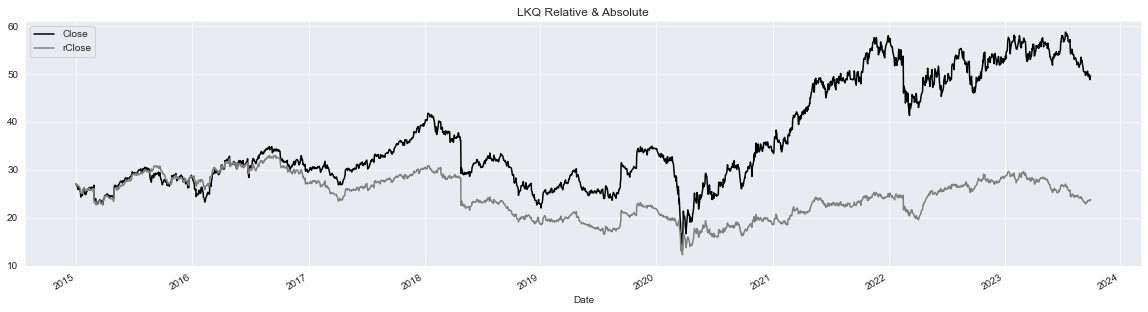

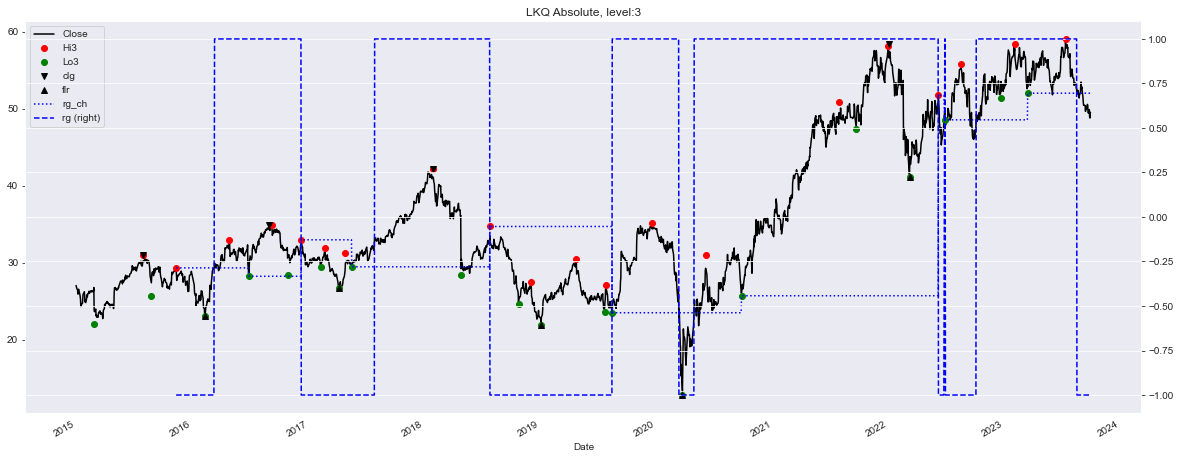

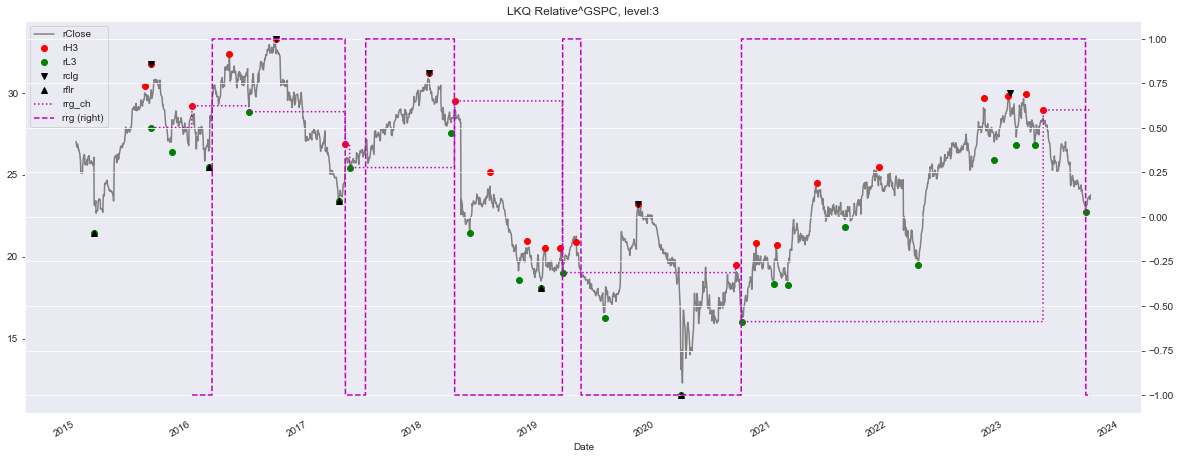

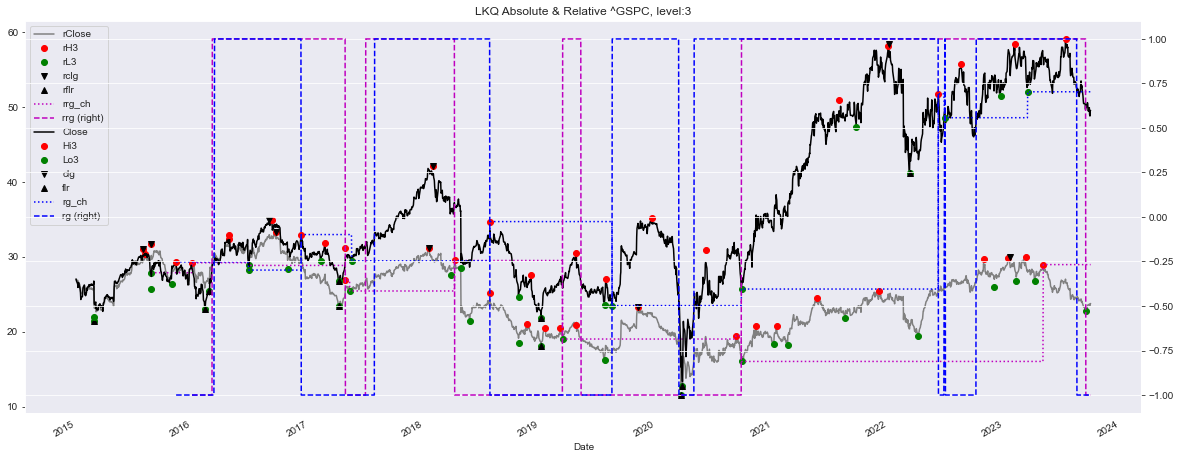

In [24]:
from notes.scanner_engine import swings, regime, lower_upper_OHLC, regime_sma, regime_breakout, turtle_trader

# CHAPTER 5: Regime Definition
ticker = 'LKQ'
lvl = 3 # Try different levels to see

df = round(yf.download(tickers= ticker,start= start, end = end,interval = "1d",
                 group_by = 'column',auto_adjust = True, prepost = True,
                 treads = True, proxy = None),dgt)

swing_opts = {
    'r_vol': r_vol,
    'd_vol': d_vol,
    'dist_pct': dist_pct,
    'lvl': lvl,
    'vlty_n': vlty_n,
    'retrace_pct': retrace_pct,
    'start': start,
    'bm_col': bm_col,
    'bm_df': bm_df
}
regime_opts = {
    'lvl': lvl,
    'vlty_n': vlty_n,
    'threshold': threshold,
}
df = swings(df,rel = False, **swing_opts)
df = regime(df,rel = False, **regime_opts)
df = swings(df,rel = True, **swing_opts)
df = regime(df,rel= True, **regime_opts)
_o,_h,_l,_c = lower_upper_OHLC(df,relative = False)

for a in range(2):
    df['sma'+str(_c)[:1]+str(st)+str(lt)] = regime_sma(df,_c,st,lt)
    df['bo'+str(_h)[:1]+str(_l)[:1]+ str(slow)] = regime_breakout(df,_h,_l,window)
    df['tt'+str(_h)[:1]+str(fast)+str(_l)[:1]+ str(slow)] = turtle_trader(df, _h, _l, slow, fast)
    _o,_h,_l,_c = lower_upper_OHLC(df,relative = True)

df[['Close','rClose']].plot(figsize=(20,5),style=['k','grey'],title = str.upper(ticker)+ ' Relative & Absolute')

plot_abs_cols = ['Close','Hi'+str(lvl), 'Lo'+str(lvl),'clg','flr','rg_ch','rg']
plot_abs_style = ['k', 'ro', 'go', 'kv', 'k^','b:','b--']
y2_abs = ['rg']
plot_rel_cols = ['rClose','rH'+str(lvl), 'rL'+str(lvl),'rclg','rflr','rrg_ch','rrg']
plot_rel_style = ['grey', 'ro', 'go', 'kv', 'k^','m:','m--']
y2_rel = ['rrg']
df[plot_abs_cols].plot(secondary_y= y2_abs,figsize=(20,8),
            title = str.upper(ticker)+ ' Absolute, level:'+str(lvl),# grid=True,
            style=plot_abs_style)

df[plot_rel_cols].plot(secondary_y=y2_rel,figsize=(20,8),# grid=True,
            title = str.upper(ticker)+ ' Relative'+str.upper(bm_ticker)+', level:'+str(lvl),
            style=plot_rel_style)

df[plot_rel_cols + plot_abs_cols].plot(secondary_y=y2_rel + y2_abs,figsize=(20,8),# grid=True,
            title = str.upper(ticker)+ ' Absolute & Relative '+str.upper(bm_ticker)+', level:'+str(lvl),
            style=plot_rel_style + plot_abs_style)

### Regime combo visualisation
This final block of code plots the data in a more visually appealing way

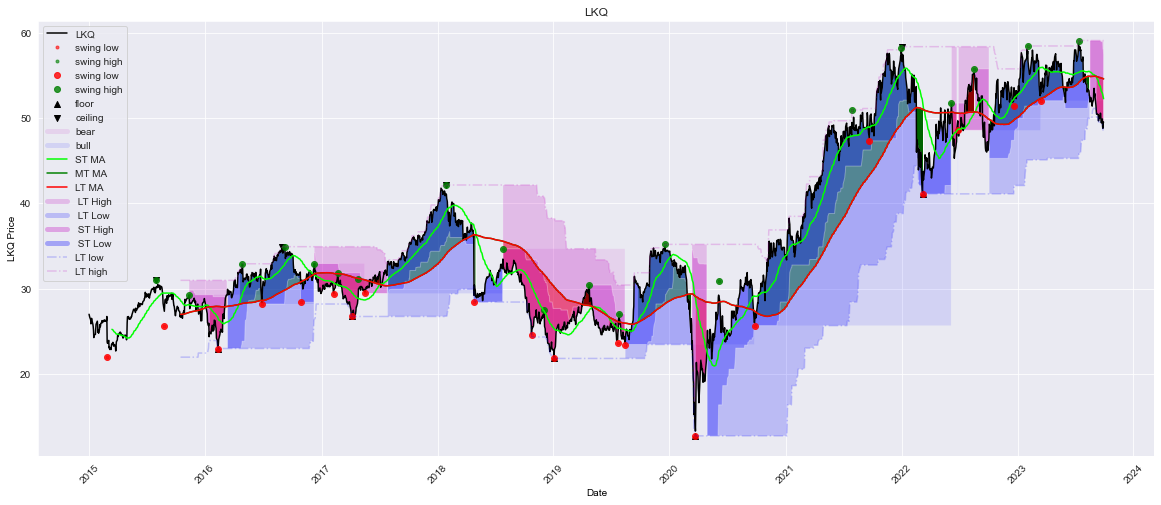

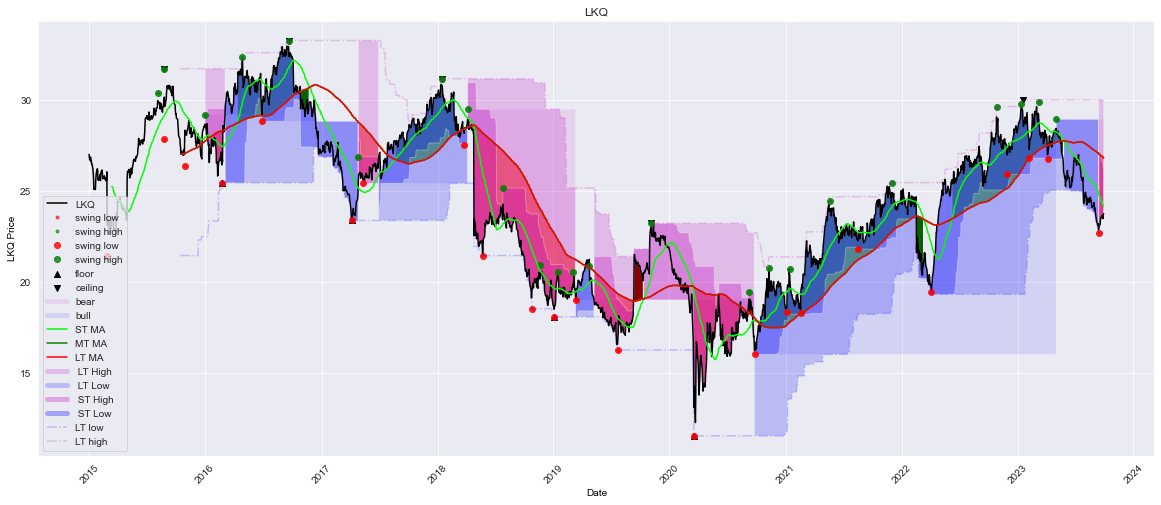

In [25]:
from notes.scanner_engine import graph_regime_combo

# CHAPTER 5: Regime Definition
mav = [fast, slow, 200]
bo = [fast, slow]
# ma_st = ma_mt = ma_lt = lt_lo = lt_hi = st_lo = st_hi = 0

_o,_h,_l,_c = lower_upper_OHLC(df,relative = False)
ma_st,ma_mt,ma_lt = [df[_c].rolling(mav[t]).mean() for t in range(len(mav))]
st_lo,lt_lo = [df[_l].rolling(bo[t]).min() for t in range(len(bo))]
st_hi,lt_hi = [df[_h].rolling(bo[t]).max() for t in range(len(bo))]

rg_combo = ['Close','rg','Lo'+str(lvl),'Hi'+str(lvl),'Lo'+str(lvl),'Hi'+str(lvl),'clg','flr','rg_ch']
_c,rg,lo,hi,slo,shi,clg,flr,rg_ch =[rg_combo[r] for r in range(len(rg_combo)) ]
graph_regime_combo(ticker,df,_c,rg,lo,hi,slo,shi,clg,flr,rg_ch,ma_st,ma_mt,ma_lt,lt_lo,lt_hi,st_lo,st_hi)

_o,_h,_l,_c = lower_upper_OHLC(df,relative = True)
ma_st,ma_mt,ma_lt = [df[_c].rolling(mav[t]).mean() for t in range(len(mav))]
st_lo,lt_lo = [df[_l].rolling(bo[t]).min() for t in range(len(bo))]
st_hi,lt_hi = [df[_h].rolling(bo[t]).max() for t in range(len(bo))]

rrg_combo = ['rClose','rrg','rL'+str(lvl),'rH'+str(lvl),'rL'+str(lvl),'rH'+str(lvl),'rclg','rflr','rrg_ch']
_c,rg,lo,hi,slo,shi,clg,flr,rg_ch =[rrg_combo[r] for r in range(len(rrg_combo)) ]
graph_regime_combo(ticker,df,_c,rg,lo,hi,slo,shi,clg,flr,rg_ch,ma_st,ma_mt,ma_lt,lt_lo,lt_hi,st_lo,st_hi)

In [26]:
from notes.scanner_engine import swings, regime, lower_upper_OHLC, regime_sma, regime_breakout, turtle_trader

# CHAPTER 5: Regime Definition
ticker = 'LKQ'
lvl = 3 # Try different levels to see

df_rel = pd.read_sql(f'SELECT * FROM enhanced_price WHERE symbol = \'{ticker}\'', engine)
df_abs = df_rel.loc[df_rel.is_relative == False].reset_index(drop=True)
df_rel = df_rel.loc[df_rel.is_relative == True].reset_index(drop=True)

def add_regimes(data):
    _o,_h,_l,_c = 'open', 'high', 'low', 'close'
    data['sma'] = regime_sma(data,_c,st,lt)
    data['bo'] = regime_breakout(data,_h,_l,window)
    data['tt'] = turtle_trader(data, _h, _l, slow, fast)
    return data

df_rel = add_regimes(df_rel)
df_abs = add_regimes(df_abs)




NameError: name 'engine' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Assuming your absolute DataFrame is named 'df_abs' and relative DataFrame is named 'df_rel'
plot_cols = ['close','hi'+str(lvl), 'lo'+str(lvl),'clg','flr','rg_ch','rg']
plot_style1 = ['k', 'ro', 'go', 'kv', 'k^','b:','b--']
plot_style2 = ['grey', 'ro', 'go', 'kv', 'k^','m:','m--']
# Plotting absolute data
df_abs[plot_cols].plot(
    secondary_y='rg',
    figsize=(20,8),
    title=str.upper(ticker) + ' Absolute, level:' + str(lvl),
    style=plot_style1)

# Plotting relative data
df_rel[plot_cols].plot(
    secondary_y='rg',
    figsize=(20,8),
    title=str.upper(ticker) + ' Relative' + str.upper(bm_ticker) + ', level:' + str(lvl),
    style=plot_style2)

# Plotting absolute and relative data together
df_combined = pd.concat([df_abs, df_rel])  # Combining the absolute and relative DataFrames

y2 = ['rg']
df_combined[plot_cols].plot(
    secondary_y=y2,
    figsize=(20,8),
    title=str.upper(ticker) + ' Absolute & Relative ' + str.upper(bm_ticker) + ', level:' + str(lvl),
    style=plot_style1 + plot_style2)

# Show the plots
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()
# Plot absolute values on the primary y-axis
sns.lineplot(data=df_abs, x=df_abs.index, y='close', label='abs_close', ax=ax1)
sns.lineplot(data=df_abs, x=df_abs.index, y='rg', label='abs_rg', ax=ax2)
sns.scatterplot(data=df_abs, x=df_abs.index, y='hi'+str(lvl), label='abs_hi'+str(lvl), ax=ax1)
sns.scatterplot(data=df_abs, x=df_abs.index, y='lo'+str(lvl), label='abs_lo'+str(lvl), ax=ax1)
sns.scatterplot(data=df_abs, x=df_abs.index, y='clg', label='abs_clg', ax=ax1)
sns.scatterplot(data=df_abs, x=df_abs.index, y='flr', label='abs_flr', ax=ax1)
sns.scatterplot(data=df_abs, x=df_abs.index, y='rg_ch', label='abs_rg_ch', ax=ax1)

# Create a secondary y-axis on the same plot


# Plot relative values on the secondary y-axis
sns.lineplot(data=df_rel, x=df_rel.index, y='close', label='rel_close', ax=ax1)
sns.lineplot(data=df_rel, x=df_rel.index, y='rg', label='rel_rg', ax=ax2)
sns.scatterplot(data=df_rel, x=df_rel.index, y='hi'+str(lvl), label='rel_hi'+str(lvl), ax=ax1)
sns.scatterplot(data=df_rel, x=df_rel.index, y='lo'+str(lvl), label='rel_lo'+str(lvl), ax=ax1)
sns.scatterplot(data=df_rel, x=df_rel.index, y='clg', label='rel_clg', ax=ax1)
sns.scatterplot(data=df_rel, x=df_rel.index, y='flr', label='rel_flr', ax=ax1)
sns.scatterplot(data=df_rel, x=df_rel.index, y='rg_ch', label='rel_rg_ch', ax=ax1)

# Customize the plot and axes
ax1.set_ylabel('Absolute Values')
ax2.set_ylabel('Relative Values')
plt.title('Absolute and Relative Values')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


In [ ]:
# select rows from regime_overview that belong to sub-industry who's delta is greater than or equal 0.5 and less than or equal -0.5
rotating_sub_industries = sub_industry_overview.loc[(sub_industry_overview['delta'] >= 0.5) | (sub_industry_overview['delta'] <= -0.5)]
target_stocks = regime_overview.loc[
    (regime_overview['GICS Sub-Industry'].isin(rotating_sub_industries.index)) &
    ((regime_overview.delta >= 0.5) | (regime_overview.delta <= -0.5))
]
